# Задача №3. DataScience case

In [740]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter("ignore")

sns.set(style="darkgrid")
%matplotlib inline

In [741]:
train = pd.read_csv('train.csv.txt', sep=',')
y = train['Outcome']
X_train = train.drop(columns=['Outcome', 'Id'])
test = pd.read_csv('test.csv.txt', sep=',')
X_test = test.drop(columns='Id')

## Рассмотрим значение таргета

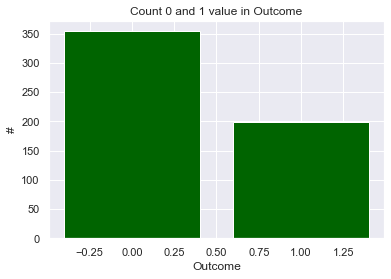

In [742]:
plt.bar([0, 1], y.value_counts(), color='darkgreen')
plt.title("Count 0 and 1 value in Outcome")
plt.xlabel("Outcome")
plt.ylabel("#")
plt.show()

In [743]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,3.913043,121.599638,68.164855,20.648551,82.711957,31.939674,0.471433,33.440217
std,3.413389,31.152296,19.960033,15.803571,116.337602,7.785607,0.332835,11.944216
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,100.000000,62.000000,0.000000,0.000000,27.200000,0.238000,24.000000
50%,3.000000,118.500000,70.000000,23.000000,41.500000,32.000000,0.370500,29.000000
75%,6.000000,140.000000,80.000000,33.000000,130.000000,35.925000,0.630250,41.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


## Исследуем на наличие выбросов и аномалий

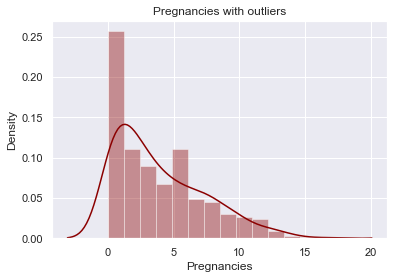

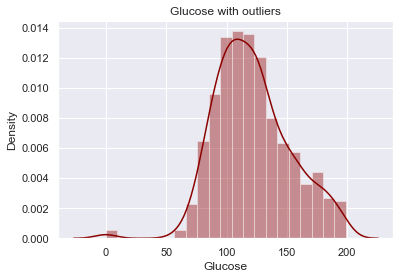

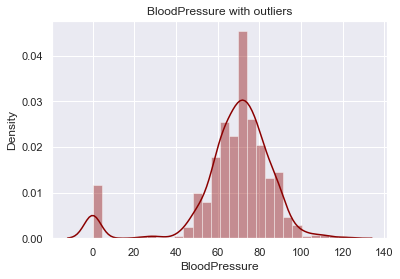

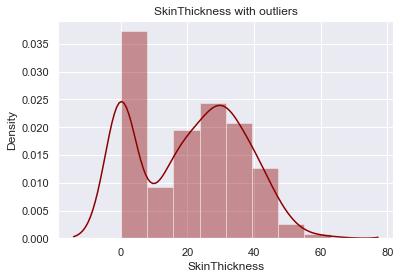

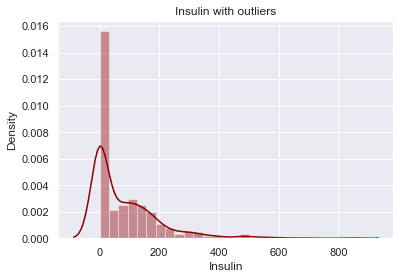

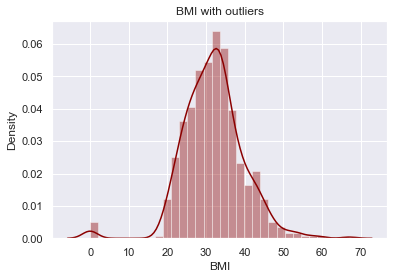

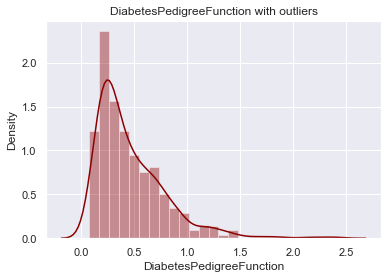

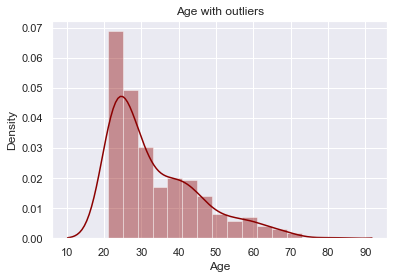

In [744]:
for feat in X_train.columns:
    sns.distplot(X_train[feat], color='darkred')
    plt.ylabel("Density")
    plt.title(feat + " with outliers")
    plt.show()

Есть показатели с нулевым кровеносным давлением, skin thickness, insulin, ИМТ. Для живого человека это не норма. 
Воспримим такие значения как аномальные. Если бы этот датасет был больше, мы бы убрали такие показатели из обучения
Но в данном для каждого такого признака добавим столбец с бинарным значением, где для сооветсвующего объекта
1 -- есть 0, 0 -- нет 0

Заменим 0 на среднее по признаку

In [745]:
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for feat in features:
    X_train['zero' + feat] = (X_train[feat] == 0) * 1
    X_test['zero' + feat] = (X_test[feat] == 0) * 1
    X_train.loc[X_train[feat] == 0, feat] = np.nan
    X_train.loc[X_train[feat].isna(), feat] = X_train[feat].mean()
    X_test.loc[X_test[feat] == 0, feat] = np.nan
    X_test.loc[X_test[feat].isna(), feat] = X_test[feat].mean()

In [746]:
data = pd.concat([train['Outcome'], X_train[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]], axis=1)

data.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.437853,111.574192,70.192398,27.341260,144.117787,30.520772,0.423209,31.536723
1,4.762626,141.376405,74.694416,32.178984,181.252734,35.455003,0.557652,36.843434


## Посчитаем корреляцию Пирсона для общего взгляда на влияние изменения признаков на таргет

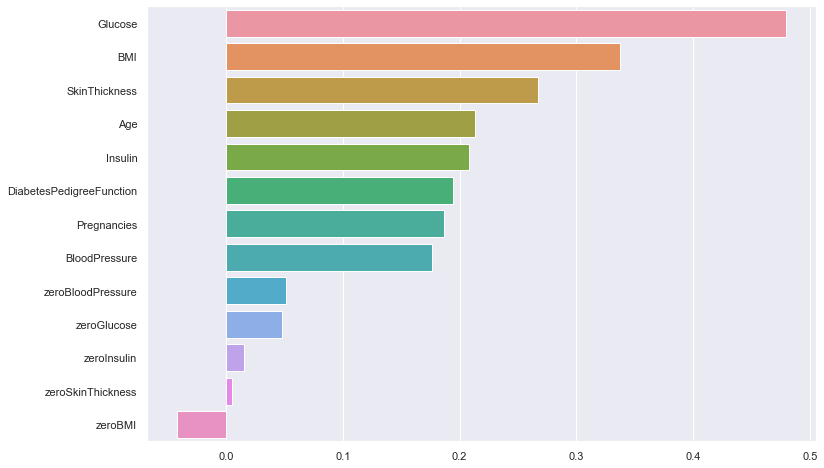

In [747]:
numeric_features = X_train.columns

correlations = X_train[numeric_features].corrwith(y).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(12, 8)

## Данные не такие объёмные, исследуем зависимость относительно каждого признака

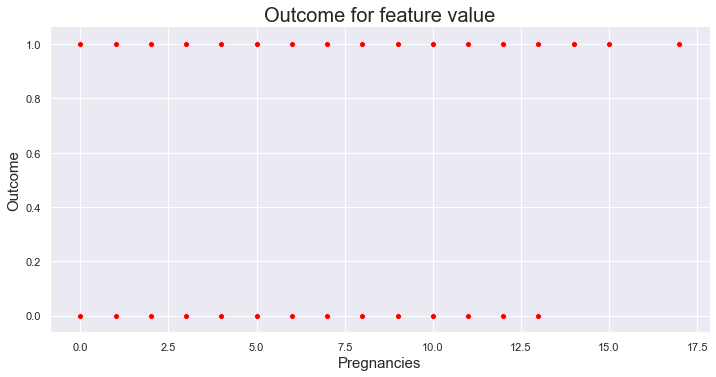

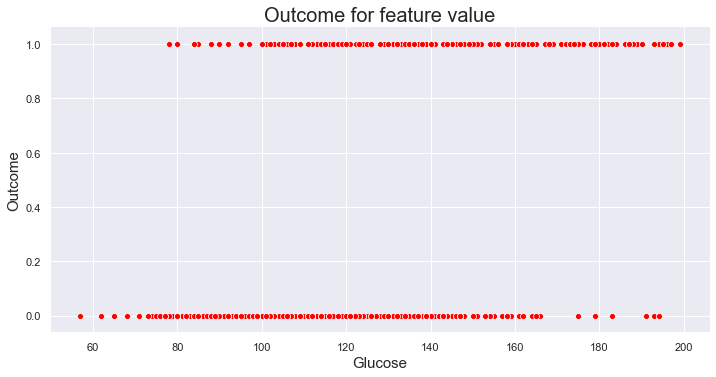

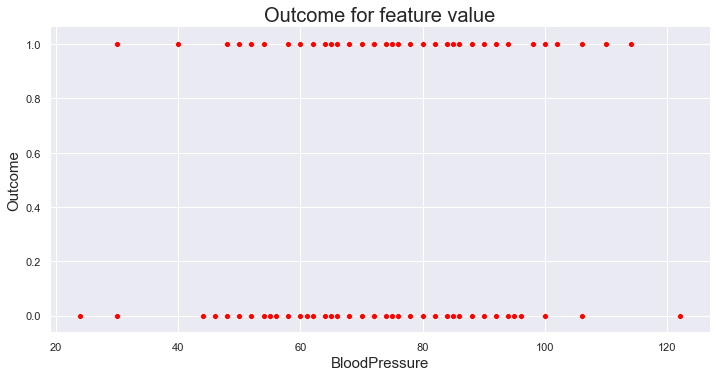

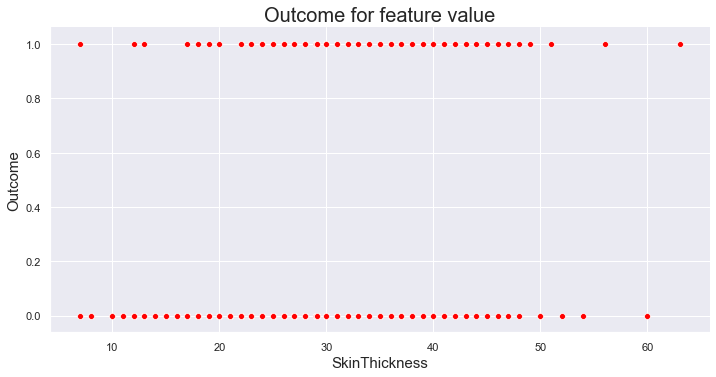

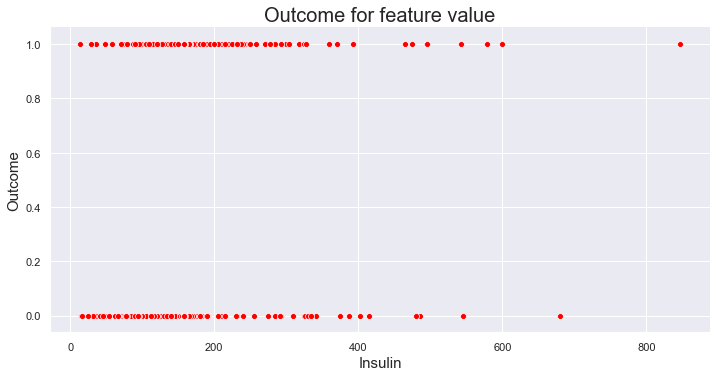

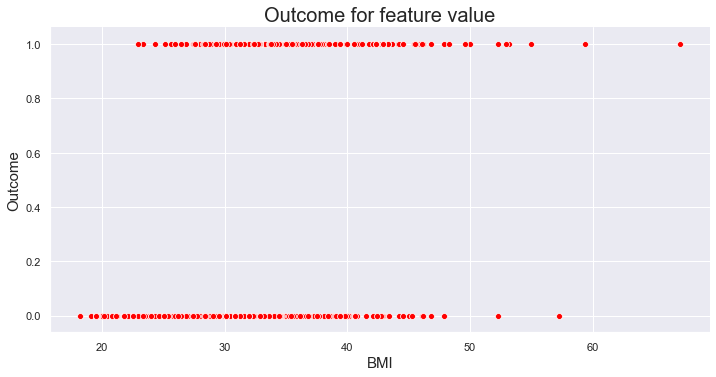

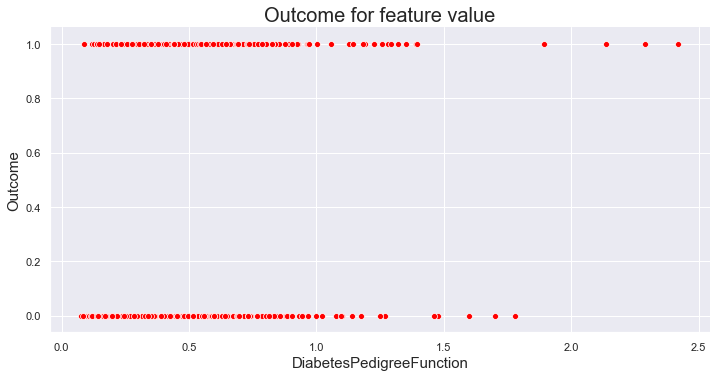

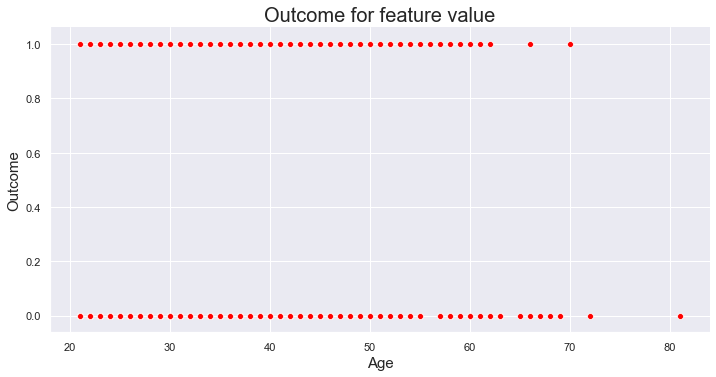

In [748]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

data = pd.concat([train['Outcome'], X_train[features]], axis=1)
for feat in features:
    sns.relplot(data=data, x=feat, y='Outcome', kind='scatter', color='red', aspect=2)
    plt.title("Outcome for feature value", fontsize = 20)
    plt.xlabel(feat, fontsize = 15)
    plt.ylabel('Outcome', fontsize = 15)
    plt.show()

## Рассмотрим отдельно взаимосвязь возраста и таргета; числа беременностей и таргета

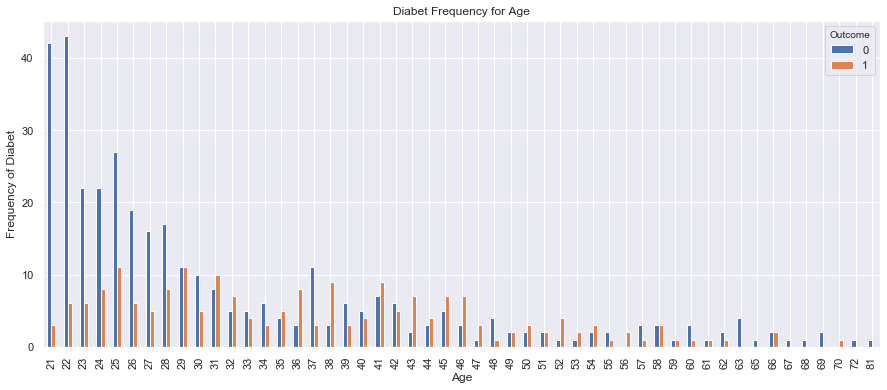

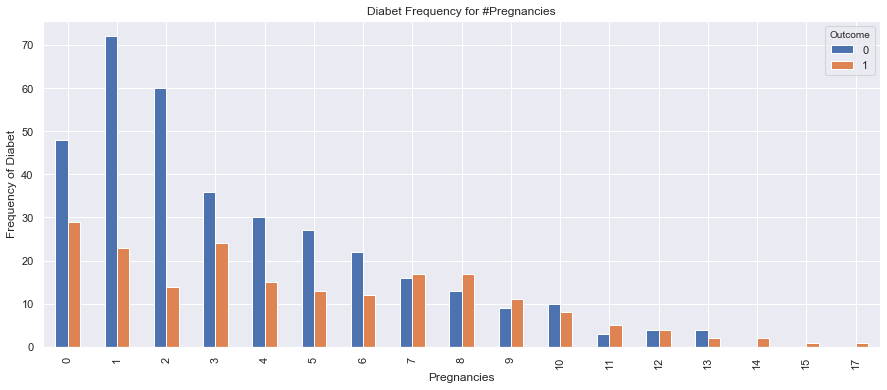

In [749]:
%matplotlib inline
pd.crosstab(X_train.Age, y).plot(kind='bar', figsize=(15, 6))
plt.title('Diabet Frequency for Age')
plt.xlabel('Age')
plt.ylabel('Frequency of Diabet')
plt.show()

pd.crosstab(X_train.Pregnancies, y).plot(kind='bar', figsize=(15, 6))
plt.title('Diabet Frequency for #Pregnancies')
plt.xlabel('Pregnancies')
plt.ylabel('Frequency of Diabet')
plt.show()

## Парные зависимости

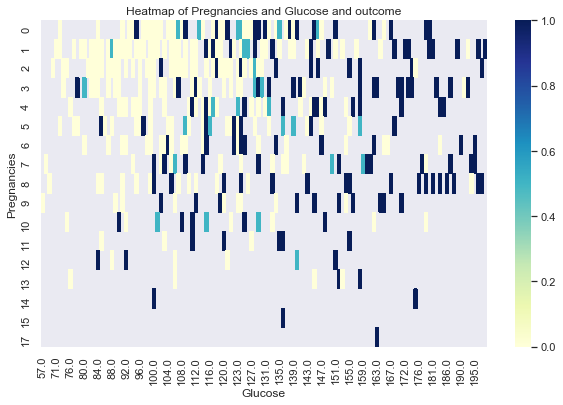

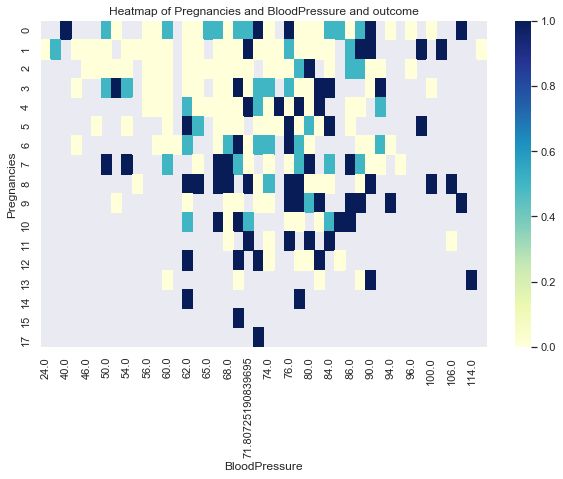

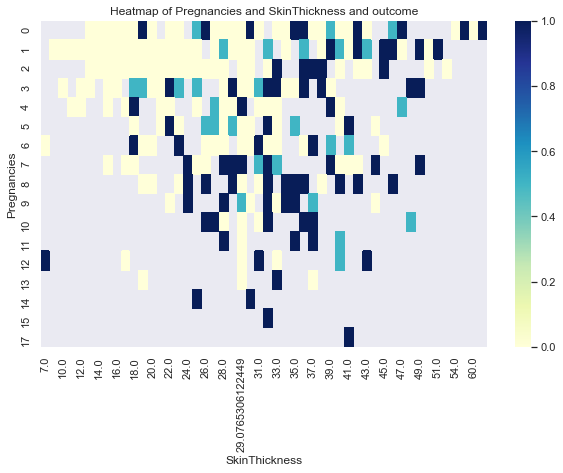

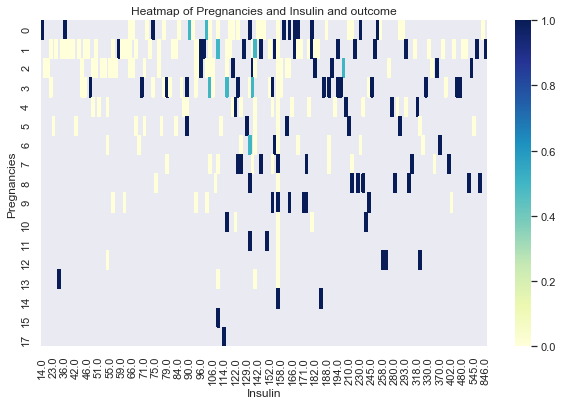

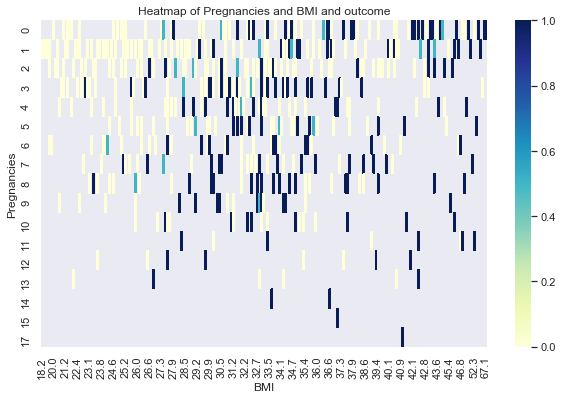

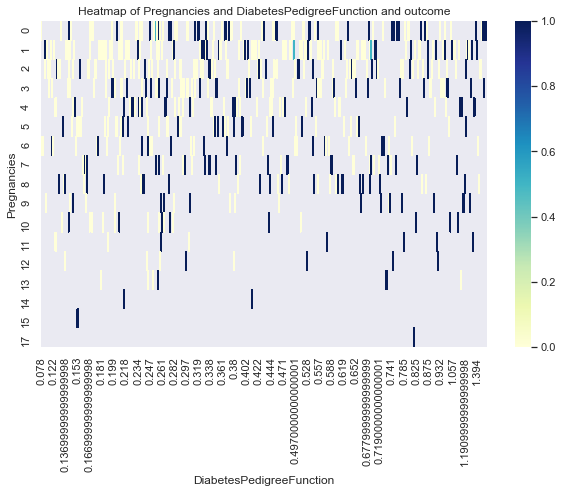

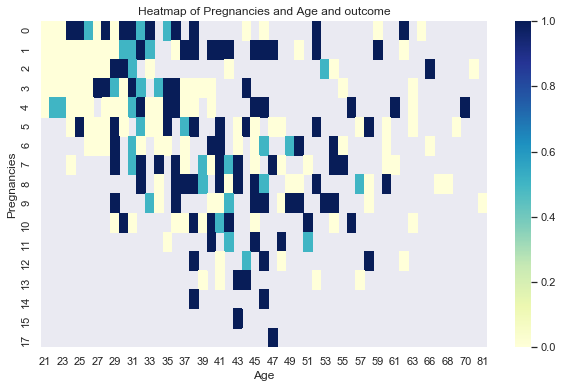

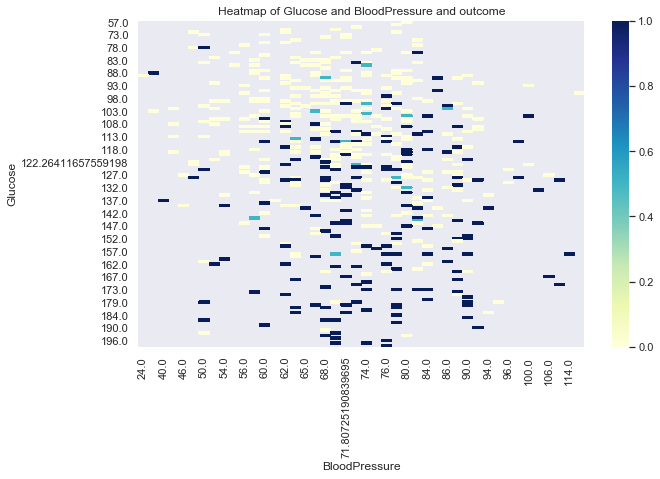

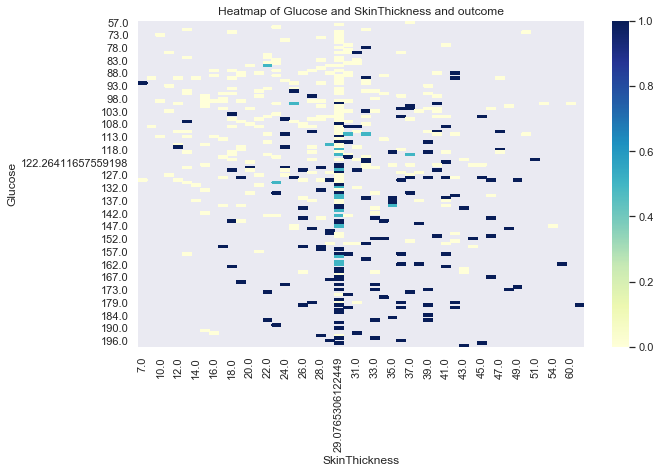

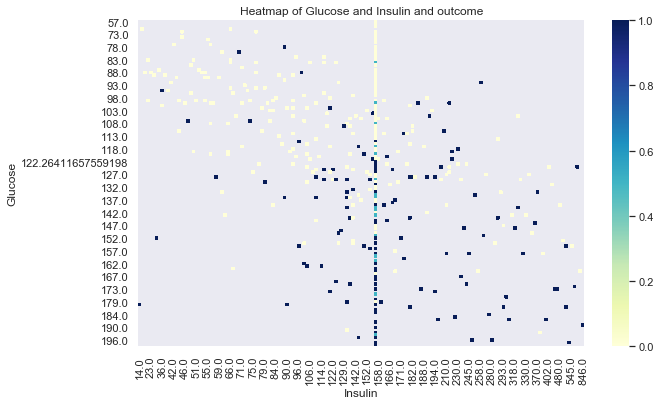

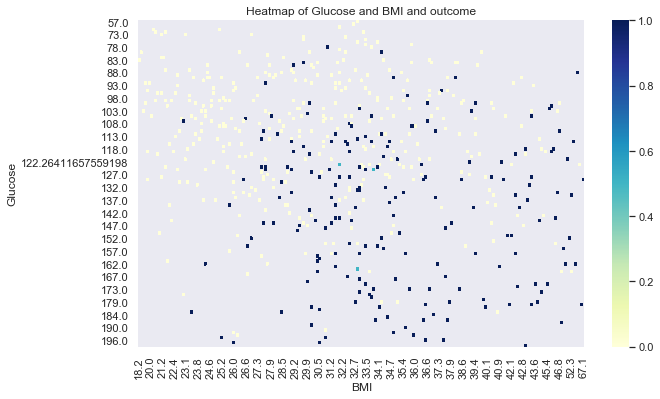

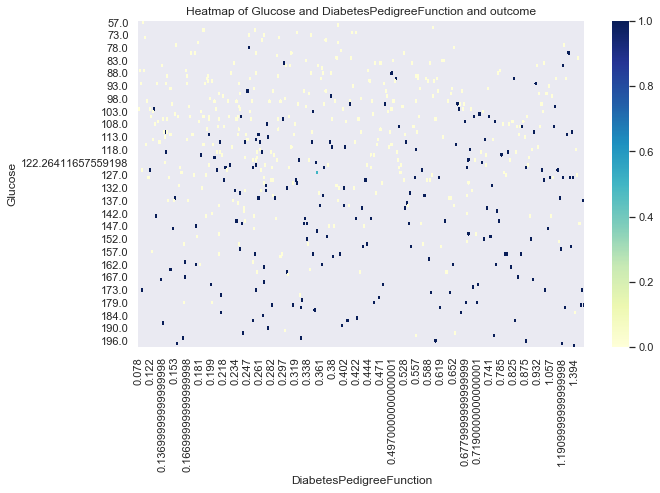

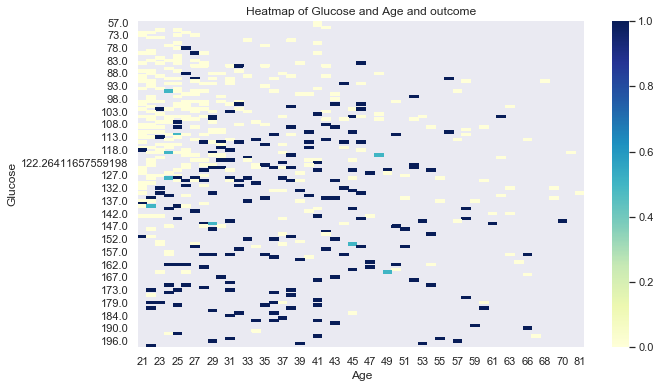

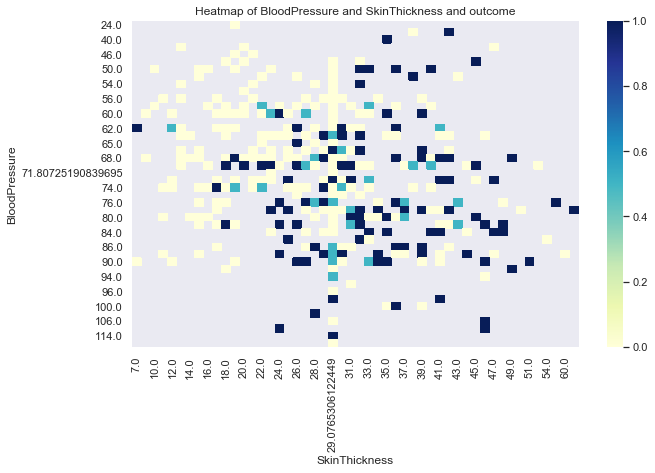

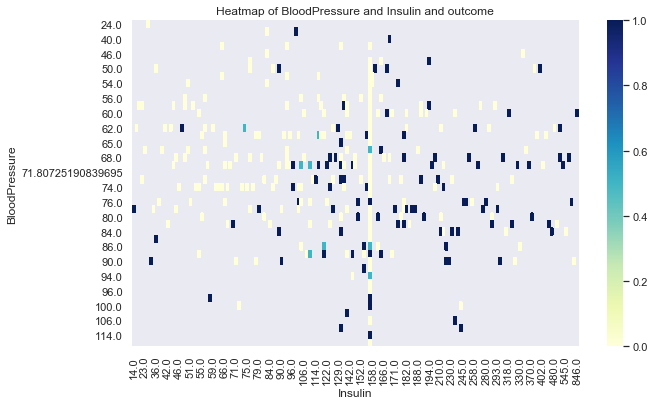

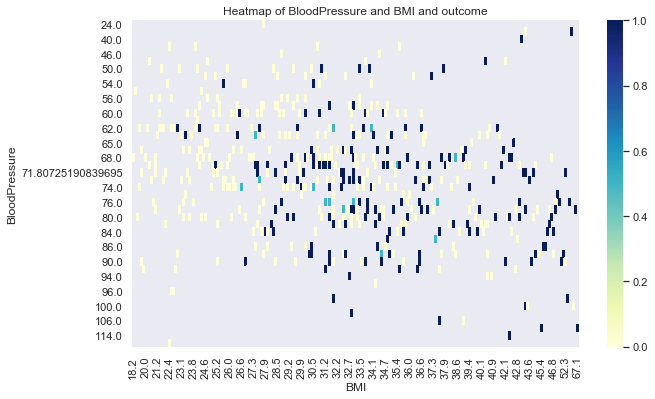

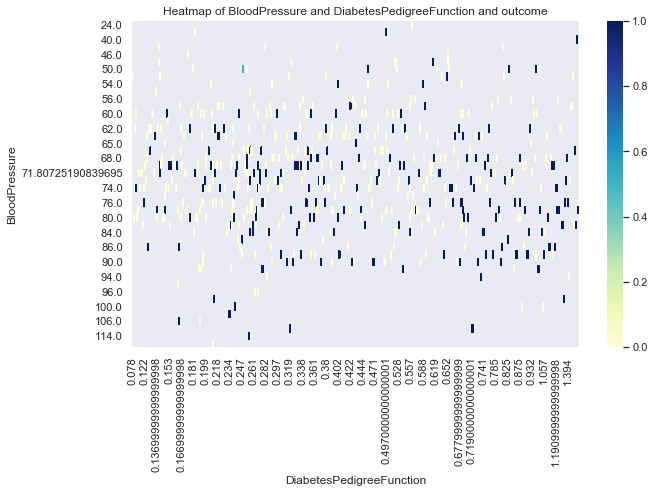

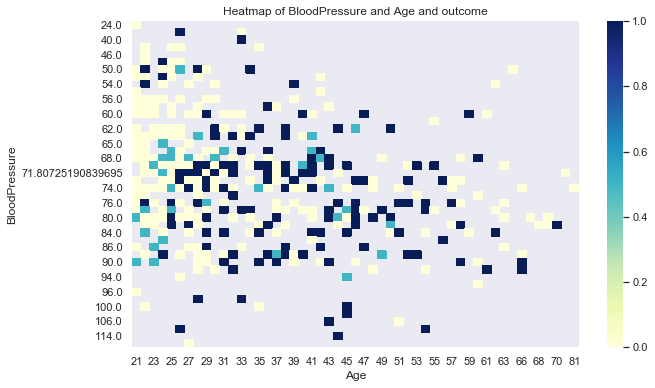

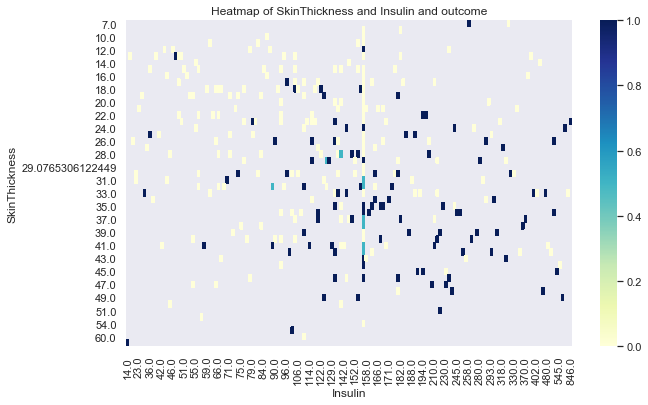

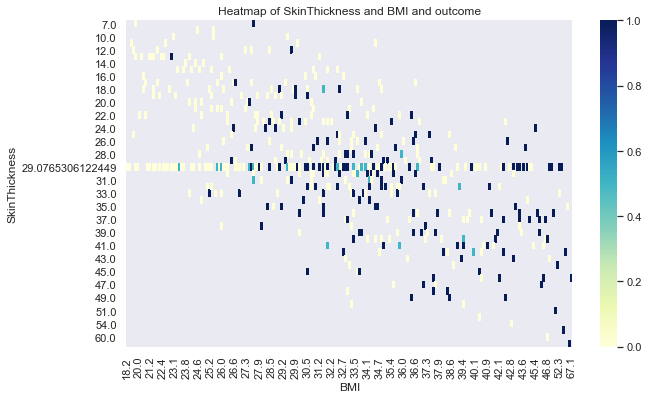

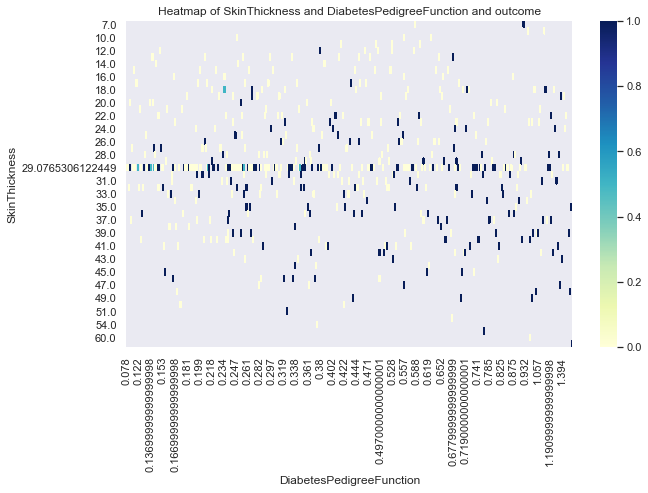

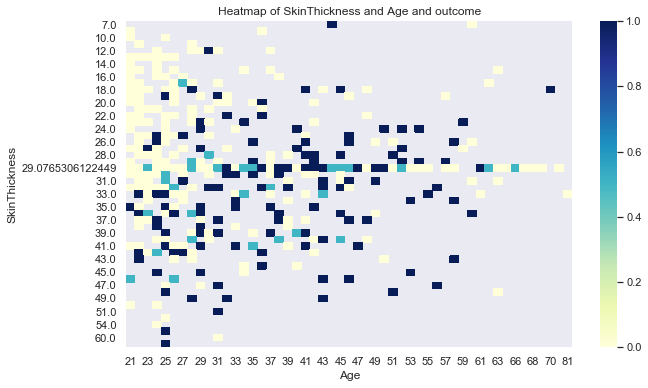

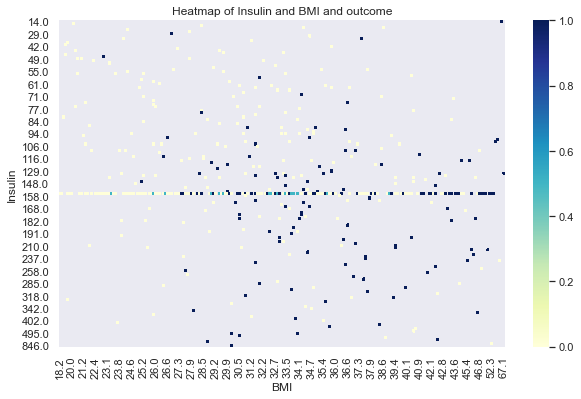

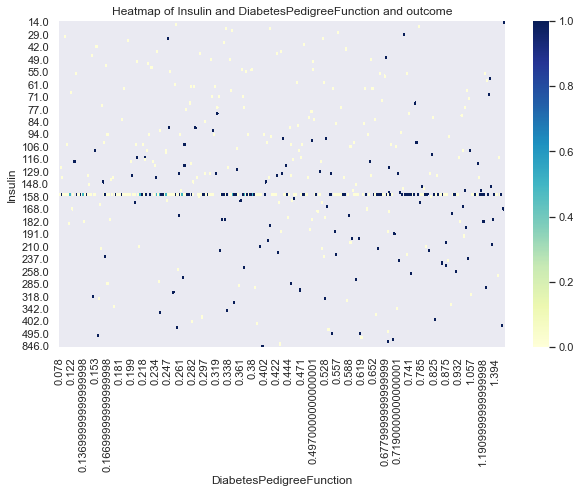

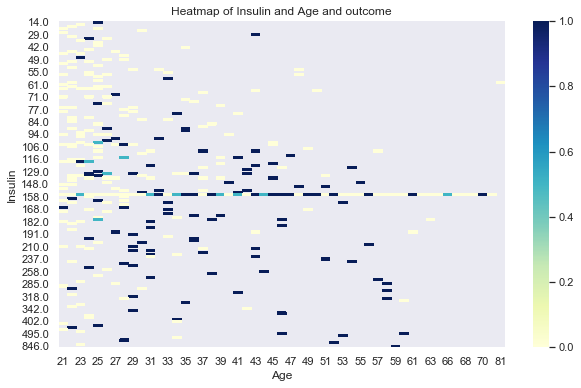

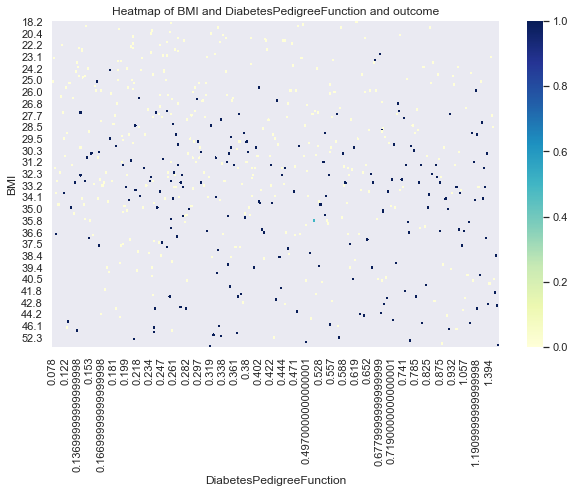

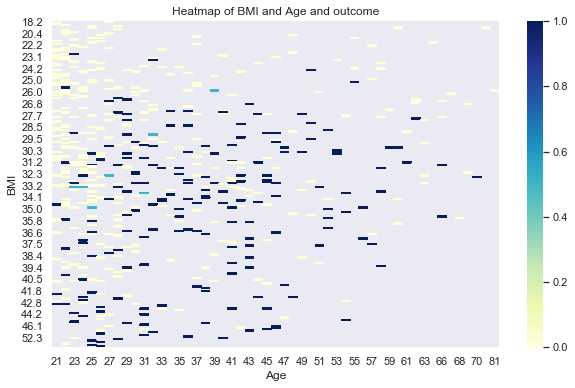

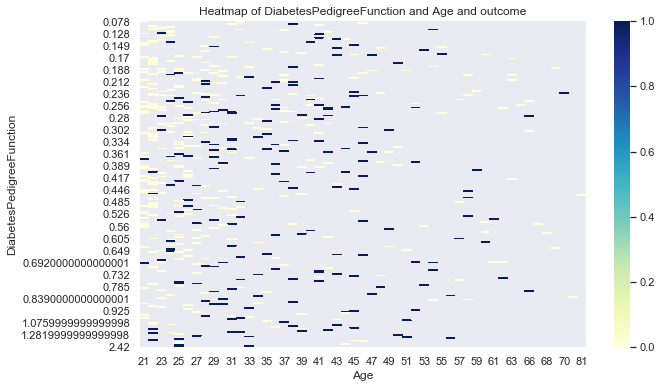

In [750]:
data = pd.concat([train['Outcome'], X_train[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]], axis=1)

for i in range(len(features) - 1):
    for j in range(i + 1, len(features)):
        ffo = data.groupby([features[i], features[j]]).median()['Outcome'].to_frame().reset_index()
        pivoted_table = ffo.pivot(index=features[i], columns=features[j], values='Outcome')
        plt.figure(figsize=(10,6))
        sns.heatmap(pivoted_table, cmap="YlGnBu")
        plt.title('Heatmap of ' + features[i] + ' and ' + features[j] + ' and ' + 'outcome')
        plt.show()

## Нормализуем выборку

In [751]:
X_train[features] = (X_train[features] - X_train[features].mean()) / X_train[features].std()
X_test[features] = (X_test[features] - X_test[features].mean()) / X_test[features].std()

In [752]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


parameters = {'C':np.logspace(-3, 2, 20)}

model = GridSearchCV(LogisticRegression(), parameters, scoring=make_scorer(precision_score))
model.fit(X_train, y)

best_c = model.best_params_['C']
print('Best C = %.3f' % best_c)

kf = KFold(n_splits=4, shuffle=True, random_state=42)
classif = LogisticRegression(C=best_c)
pred = []
y_check = []
score = []
roc = []
for train_index, test_index in kf.split(X_train):
    x_train, x_test = X_train.loc[train_index, :], X_train.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    classif.fit(x_train, y_train)
    y_pred = classif.predict(x_test)
    score.append(precision_score(y_test, y_pred))
    pred.extend(y_pred.tolist())
    y_check.extend(y_test.tolist())
    roc.extend(classif.decision_function(x_test))
print('Cross validation accuracy: %.3f' % np.array(score).mean())
classif.fit(X_train, y)
y_pred = classif.predict(X_train)
print('Train acc: %.3f' % precision_score(y, y_pred))

Best C = 0.002
Cross validation accuracy: 0.823
Train acc: 0.794


good	bad
[[350   4]
 [183  15]]


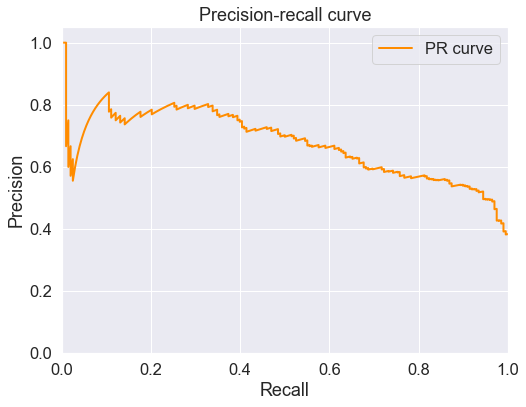

In [753]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_check, pred)
print('good\tbad')
print(confusion_matrix)

sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(8, 6))
precision_LR, recall_LR, thresholds_LR = precision_recall_curve(y_check, roc)
plt.plot(recall_LR, precision_LR, color='darkorange',
         lw=lw, label='PR curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.legend()
plt.show()

## Важность используемых признаков в модели

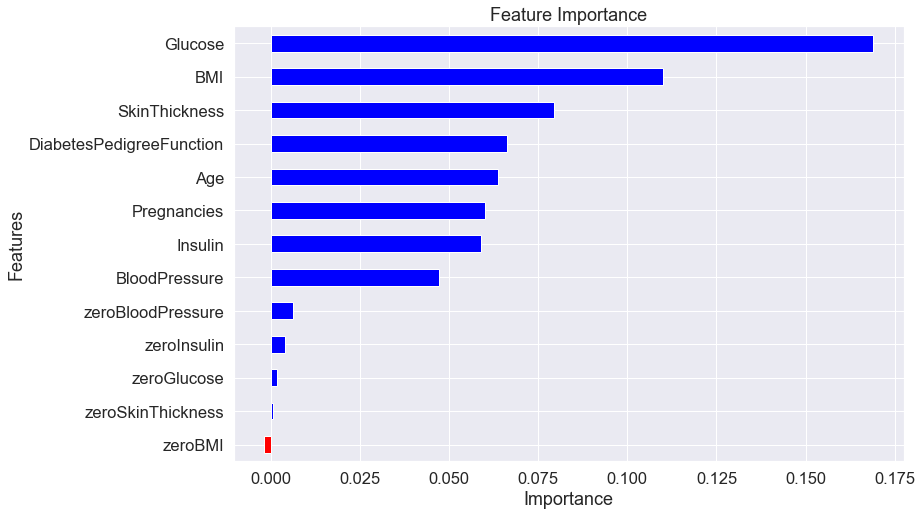

In [754]:
res = pd.DataFrame()
res['Features'] = X_train.columns
res['importance'] = classif.coef_[0]
res.sort_values(by=['importance'], ascending=True, inplace=True)
res['positive'] = res['importance'] > 0
res.set_index('Features', inplace=True)
res.importance.plot(kind='barh', figsize=(12, 8), color = res.positive.map({True: 'blue', False: 'red'}))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

In [713]:
y_pred = classif.predict(X_test)
y_pred_proba = classif.predict_proba(X_test)